<a href="https://colab.research.google.com/github/cnhzgb/MachineL/blob/main/VGG16_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ipdb
!pip install einops
import ipdb
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from einops import rearrange

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"

trans = transforms.Compose([transforms.RandomHorizontalFlip(), transforms.RandomGrayscale(), transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
dataset = datasets.CIFAR10(root="dataset/", transform=trans, download=True, train=True) # 5W张图片, 10种分类
loader = DataLoader(dataset, batch_size=100, shuffle=True)
batch_num,(image, label) = next(enumerate(loader))
print(len(dataset.classes), len(dataset), image.shape, label.shape) # 10; 5W; 100,3,32,32; 100

trans_test = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
dataset_test = datasets.CIFAR10(root="dataset/", transform=trans_test, download=True, train=False) # 1W张图片
loader_test = DataLoader(dataset_test, batch_size=100, shuffle=True)
criterion_test = nn.CrossEntropyLoss()

Files already downloaded and verified
10 50000 torch.Size([100, 3, 32, 32]) torch.Size([100])
Files already downloaded and verified


In [9]:
#  https://juejin.cn/post/6844903718098305038
class Net(nn.Module):

    def __init__(self):
        super(Net,self).__init__()
        self.conv1 = nn.Conv2d(3,64,3,padding=1)
        self.conv2 = nn.Conv2d(64,64,3,padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.bn1 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64,128,3,padding=1)
        self.conv4 = nn.Conv2d(128, 128, 3,padding=1)
        self.pool2 = nn.MaxPool2d(2, 2, padding=1)
        self.bn2 = nn.BatchNorm2d(128)

        self.conv5 = nn.Conv2d(128,128, 3,padding=1)
        self.conv6 = nn.Conv2d(128, 128, 3,padding=1)
        self.conv7 = nn.Conv2d(128, 128, 1,padding=1)
        self.pool3 = nn.MaxPool2d(2, 2, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        self.conv8 = nn.Conv2d(128, 256, 3,padding=1)
        self.conv9 = nn.Conv2d(256, 256, 3, padding=1)
        self.conv10 = nn.Conv2d(256, 256, 1, padding=1)
        self.pool4 = nn.MaxPool2d(2, 2, padding=1)
        self.bn4 = nn.BatchNorm2d(256)

        self.conv11 = nn.Conv2d(256, 512, 3, padding=1)
        self.conv12 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv13 = nn.Conv2d(512, 512, 1, padding=1)
        self.pool5 = nn.MaxPool2d(2, 2, padding=1)
        self.bn5 = nn.BatchNorm2d(512)

        self.fc14 = nn.Linear(512*4*4,1024)
        self.fc15 = nn.Linear(1024,1024)
        self.fc16 = nn.Linear(1024,10)


    def forward(self,x):
        x = self.conv1(x) # => 100,64,32,32
        x = self.conv2(x) # => ,64,32,32
        x = self.pool1(x) # => ,64,16,16
        x = self.bn1(x)
        x = F.relu(x)

        x = self.conv3(x) # => ,128,16,16
        x = self.conv4(x) # => ,128,16,16
        x = self.pool2(x) # => ,128,9,9
        x = self.bn2(x)
        x = F.relu(x)

        x = self.conv5(x) # => ,128,9,9
        x = self.conv6(x) # => ,128,9,9
        x = self.conv7(x) # => ,128,11,11
        x = self.pool3(x) # => ,128,6,6
        x = self.bn3(x)
        x = F.relu(x)

        x = self.conv8(x) # => ,256,6,6
        x = self.conv9(x) # => ,256,6,6
        x = self.conv10(x) # => ,256,8,8
        x = self.pool4(x) # => ,256,5,5
        x = self.bn4(x)
        x = F.relu(x)

        x = self.conv11(x) # => ,512,5,5
        x = self.conv12(x) # => ,512,5,5
        x = self.conv13(x) # => ,512,7,7
        x = self.pool5(x) # => ,512,4,4
        x = self.bn5(x)
        x = F.relu(x)

        x = x.view(-1,512*4*4) # 100,8192
        x = F.relu(self.fc14(x)) # 100,1024
        x = F.dropout(x, p=0.5)
        x = F.relu(self.fc15(x)) # 100,1024
        x = F.dropout(x, p=0.5)
        x = self.fc16(x) # 100,10

        return x

model = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)

In [10]:
for epoch in range(1,10):
  total_loss = []
  errorTotal = 0
  for batch_idx, (img, label) in enumerate(loader):
    img = img.to(device)
    label = label.to(device)
    outputs = model(img)
    loss = criterion(outputs, label)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss.append(loss.item())
    maxV,maxIdx = outputs.max(dim=1)
    errorNum = torch.sum(torch.ne(maxIdx, label)).item()
    errorTotal += errorNum

    if(batch_idx % 100 == 99):
      print("epoch:{} batch:{} loss:{:.2f} mean:{:.2f} error:{}/100 errorTotal:{}/{} {:.2f}%".format(
          epoch, batch_idx, loss, np.mean(total_loss), errorNum, errorTotal, (batch_idx+1)*100, errorTotal/(batch_idx+1)))

epoch:1 batch:99 loss:1.75 mean:1.90 error:69/100 errorTotal:7210/10000 72.10%
epoch:1 batch:199 loss:1.44 mean:1.72 error:56/100 errorTotal:12943/20000 64.72%
epoch:1 batch:299 loss:1.17 mean:1.60 error:45/100 errorTotal:17885/30000 59.62%
epoch:1 batch:399 loss:1.02 mean:1.51 error:41/100 errorTotal:22272/40000 55.68%
epoch:1 batch:499 loss:1.12 mean:1.43 error:39/100 errorTotal:26167/50000 52.33%
epoch:2 batch:99 loss:0.90 mean:1.03 error:29/100 errorTotal:3586/10000 35.86%
epoch:2 batch:199 loss:0.87 mean:1.00 error:30/100 errorTotal:6987/20000 34.94%
epoch:2 batch:299 loss:0.80 mean:0.97 error:30/100 errorTotal:10210/30000 34.03%
epoch:2 batch:399 loss:0.76 mean:0.95 error:26/100 errorTotal:13267/40000 33.17%
epoch:2 batch:499 loss:0.71 mean:0.93 error:25/100 errorTotal:16193/50000 32.39%
epoch:3 batch:99 loss:0.73 mean:0.79 error:29/100 errorTotal:2780/10000 27.80%
epoch:3 batch:199 loss:0.67 mean:0.78 error:23/100 errorTotal:5362/20000 26.81%
epoch:3 batch:299 loss:0.71 mean:0.7

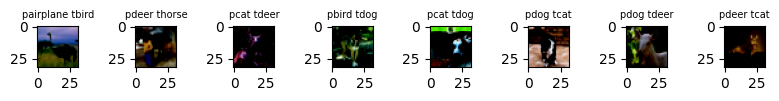

batch:9 loss:0.48 mean:0.64 error:18/100 errorTotal:199/1000 19.90%


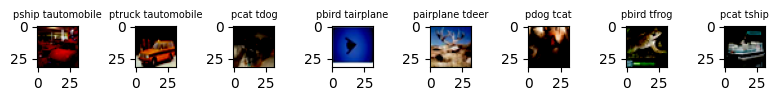

batch:19 loss:0.64 mean:0.58 error:21/100 errorTotal:365/2000 18.25%


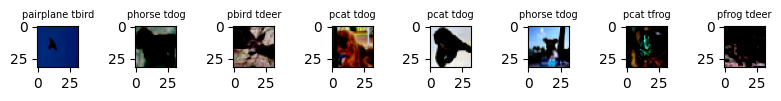

batch:29 loss:0.80 mean:0.59 error:25/100 errorTotal:551/3000 18.37%


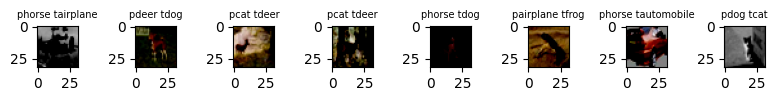

batch:39 loss:0.44 mean:0.57 error:14/100 errorTotal:715/4000 17.88%


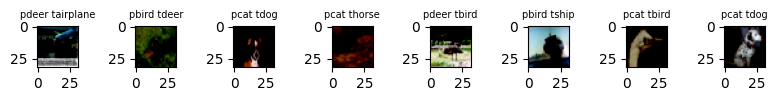

batch:49 loss:0.67 mean:0.58 error:22/100 errorTotal:903/5000 18.06%


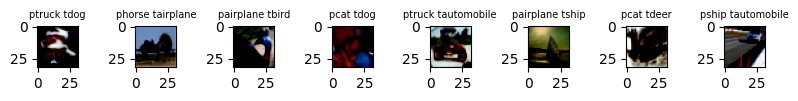

batch:59 loss:0.61 mean:0.57 error:18/100 errorTotal:1077/6000 17.95%


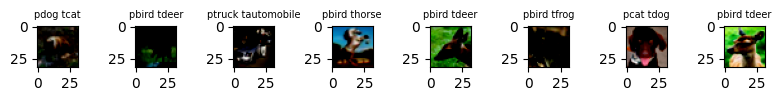

batch:69 loss:0.60 mean:0.57 error:22/100 errorTotal:1253/7000 17.90%


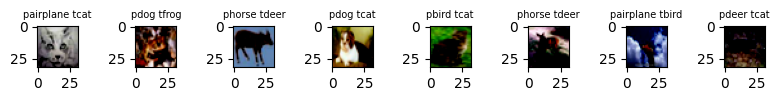

batch:79 loss:0.74 mean:0.57 error:21/100 errorTotal:1449/8000 18.11%


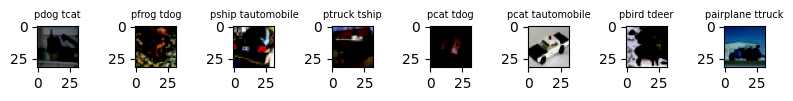

batch:89 loss:0.59 mean:0.57 error:19/100 errorTotal:1621/9000 18.01%


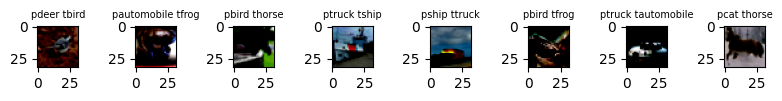

batch:99 loss:0.73 mean:0.57 error:23/100 errorTotal:1823/10000 18.23%


In [12]:
total_loss = []
errorTotal = 0
for batch_idx, (img, label) in enumerate(loader_test): # 1W张图片, 100批, 100,3,32,32
  img = img.to(device)
  label = label.to(device)

  output = model(img)
  loss = criterion_test(output, label)
  total_loss.append(loss.item())

  maxV,maxIdx = output.max(dim=1)
  errorNum = torch.sum(torch.ne(maxIdx, label)).item()
  errorTotal += errorNum

  noMatchIdx = torch.nonzero(torch.ne(maxIdx, label)).view(-1)

  if(batch_idx % 10 == 9):
    if errorNum > 8: colNum = 8
    else: colNum = errorNum
    fig, axs = plt.subplots(1, colNum, figsize=(colNum, 1))
    for i, ax in enumerate(axs.flatten()):
      idx = noMatchIdx[i]
      ax.imshow(rearrange(img[idx], 'c h w -> h w c').cpu()) # 3,32,32 => 32,32,3
      ax.set_title('p{} t{}'.format(dataset.classes[maxIdx[idx]], dataset.classes[label[idx]]), fontsize=7)
    plt.tight_layout()
    plt.show()
    print("batch:{} loss:{:.2f} mean:{:.2f} error:{}/100 errorTotal:{}/{} {:.2f}%".format(batch_idx, loss, np.mean(total_loss), errorNum, errorTotal, (batch_idx+1)*100, errorTotal/(batch_idx+1)))